In [1]:
from crowd_evaluation import ConfidenceEvaluatorNew, ConfidenceEvaluatorOld
from datasets import BicyclesDataset
import numpy as np
import plotly.graph_objects as go
from tqdm.notebook import tqdm

In [13]:
dataset = BicyclesDataset(
    '/Users/julianassmann/Documents/Bachelor-Thesis/Code/datasets/bicycles/bicycles_with_truth.csv')
# evaluater = ConfidenceEvaluatorNew(dataset)
evaluater = ConfidenceEvaluatorOld(dataset)
ps = np.zeros(len(dataset.workers), dtype=np.float32)
confs = np.zeros(len(dataset.workers), dtype=np.float32)
pbar = tqdm(total=len(dataset.workers))
confidence_level = 0.95
for i, worker in enumerate(dataset.workers):
    try:
        # p, conf = evaluater.evaluate_worker_with_confidence(worker, 0.9, min_shared_samples=1000)
        p, conf = evaluater.evaluate_worker_with_confidence(worker, confidence_level)
    except ValueError:
        # p, conf = evaluater.evaluate_worker_with_confidence(worker, 0.9, min_shared_samples=50)
        p, conf = evaluater.evaluate_worker_with_confidence(worker, confidence_level)
    ps[i] = p
    confs[i] = conf
    pbar.update(1)


# fig.write_image('bicycles_95_confidence.png', scale=5)

  0%|          | 0/20 [00:00<?, ?it/s]

In [14]:
ps, confs

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.], dtype=float32))

In [15]:
ind = dataset.workers
x_labels = np.char.add(np.full(dataset.num_workers, "W"), np.char.mod('%d', ind+1))
fig = go.Figure()
fig.add_trace(go.Bar(y=dataset.get_measured_error_rates_for_workers(dataset.workers)*100, name=r'$p_{measured}$', x=x_labels))
fig.add_trace(go.Bar(y=ps*100, name=r'$p_{est}$', error_y=dict(type='data', array=confs*100), x=x_labels))
fig.update_layout(barmode='group')
fig.show()
fig.write_image('figure.png', scale=2)

In [5]:
np.corrcoef(ps,dataset.get_measured_error_rates_for_workers(dataset.workers))

/opt/homebrew/lib/python3.9/site-packages/numpy/lib/function_base.py:2829: RuntimeWarning:

invalid value encountered in true_divide

/opt/homebrew/lib/python3.9/site-packages/numpy/lib/function_base.py:2830: RuntimeWarning:

invalid value encountered in true_divide



array([[nan, nan],
       [nan,  1.]])

In [6]:
from crowd_evaluation import VoteAggregator

ps_dict = dict(zip(dataset.workers, ps))
confs_dict = dict(zip(dataset.workers, confs))
labels, labels_accuracy, est_accuracy, guaranteed_accuracy = \
    VoteAggregator.majority_vote_with_accuracies(dataset, dataset.samples, ps_dict, confs_dict, 0.5)
ground_truth = dataset.get_ground_truth_for_samples(dataset.samples)
measured_accuracy = np.count_nonzero(np.where(ground_truth == labels, 1, 0)) / len(ground_truth)
print('Majority evaluator')
print('est_accuracy', est_accuracy)
print('guaranteed_accuracy', guaranteed_accuracy)
print('measured_accuracy', measured_accuracy)

/Users/julianassmann/PycharmProjects/Bachelor/crowd_evaluation/vote_aggregator.py:119: RuntimeWarning:

invalid value encountered in long_scalars



Majority evaluator
est_accuracy 0.5
guaranteed_accuracy 0.25
measured_accuracy 0.49845338046840476


In [7]:
from crowd_evaluation import VoteAggregator

ps_dict = dict(zip(dataset.workers, ps))
confs_dict = dict(zip(dataset.workers, confs))

labels, _, est_accuracy, guaranteed_accuracy = \
    VoteAggregator.weighted_vote_with_accuracies(dataset,dataset.samples, ps_dict, confs_dict, 0.5)
ground_truth = dataset.get_ground_truth_for_samples(dataset.samples)
measured_accuracy = np.count_nonzero(np.where(ground_truth == labels, 1, 0)) / len(ground_truth)
print('Majority evaluator')
print('est_accuracy', est_accuracy)
print('guaranteed_accuracy', guaranteed_accuracy)
print('measured_accuracy', measured_accuracy)

Majority evaluator
est_accuracy 0.5
guaranteed_accuracy 0.25
measured_accuracy 0.49845338046840476


In [8]:
from crowd_evaluation import VoteAggregator

ps_dict = dict(zip(dataset.workers, ps))
confs_dict = dict(zip(dataset.workers, confs))

filtered_workers = VoteAggregator.filter_spammers(dataset.workers, 0.02, ps, confs, method="conservative")

labels, labels_accuracy, est_accuracy, guaranteed_accuracy = \
    VoteAggregator.weighted_vote_with_accuracies(dataset,dataset.samples, ps_dict, confs_dict, 0.5, blocked_workers=filtered_workers)
measured_accuracy = np.count_nonzero(np.where(ground_truth == labels, 1, 0)) / len(ground_truth)
print('est_accuracy', est_accuracy)
print('guaranteed_accuracy', guaranteed_accuracy)
print('measured_accuracy', measured_accuracy)

est_accuracy 0.5
guaranteed_accuracy 0.25
measured_accuracy 0.49845338046840476


In [9]:
from crowd_evaluation import VoteAggregator

ps_dict = dict(zip(dataset.workers, dataset.get_measured_error_rates_for_workers(dataset.workers)))
confs_dict = dict(zip(dataset.workers, [0.01]*len(dataset.workers)))

filtered_workers = VoteAggregator.filter_spammers(dataset.workers, 0.02, ps, confs, method="conservative")

labels, labels_accuracy, est_accuracy, guaranteed_accuracy = \
    VoteAggregator.weighted_vote_with_accuracies(dataset,dataset.samples, ps_dict, confs_dict, 0.5)
measured_accuracy = np.count_nonzero(np.where(ground_truth == labels, 1, 0)) / len(ground_truth)
print('est_accuracy', est_accuracy)
print('guaranteed_accuracy', guaranteed_accuracy)
print('measured_accuracy', measured_accuracy)

est_accuracy 0.997808910810292
guaranteed_accuracy 0.4988129049854413
measured_accuracy 0.9771321254971277


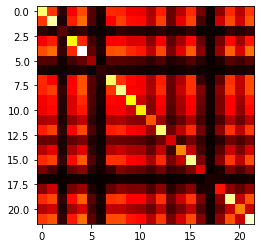

In [18]:
dataset = BicyclesDataset(
    '/Users/julianassmann/Documents/Bachelor-Thesis/Code/datasets/bicycles/bicycles_with_truth.csv')

import matplotlib.pyplot as plt
%matplotlib inline
shared_samples_count = np.zeros((len(dataset.workers), len(dataset.workers)))
for worker1 in dataset.workers:
    for worker2 in dataset.workers:
        if worker1 == worker2:
            shared_samples_count[worker1][worker2] = len(dataset.get_samples_for_worker(worker1))
        else:
            shared_samples_count[worker1][worker2] = dataset.num_shared_samples_for_workers(worker1, worker2)

plt.imshow(shared_samples_count, cmap='hot', interpolation='nearest')
plt.show()

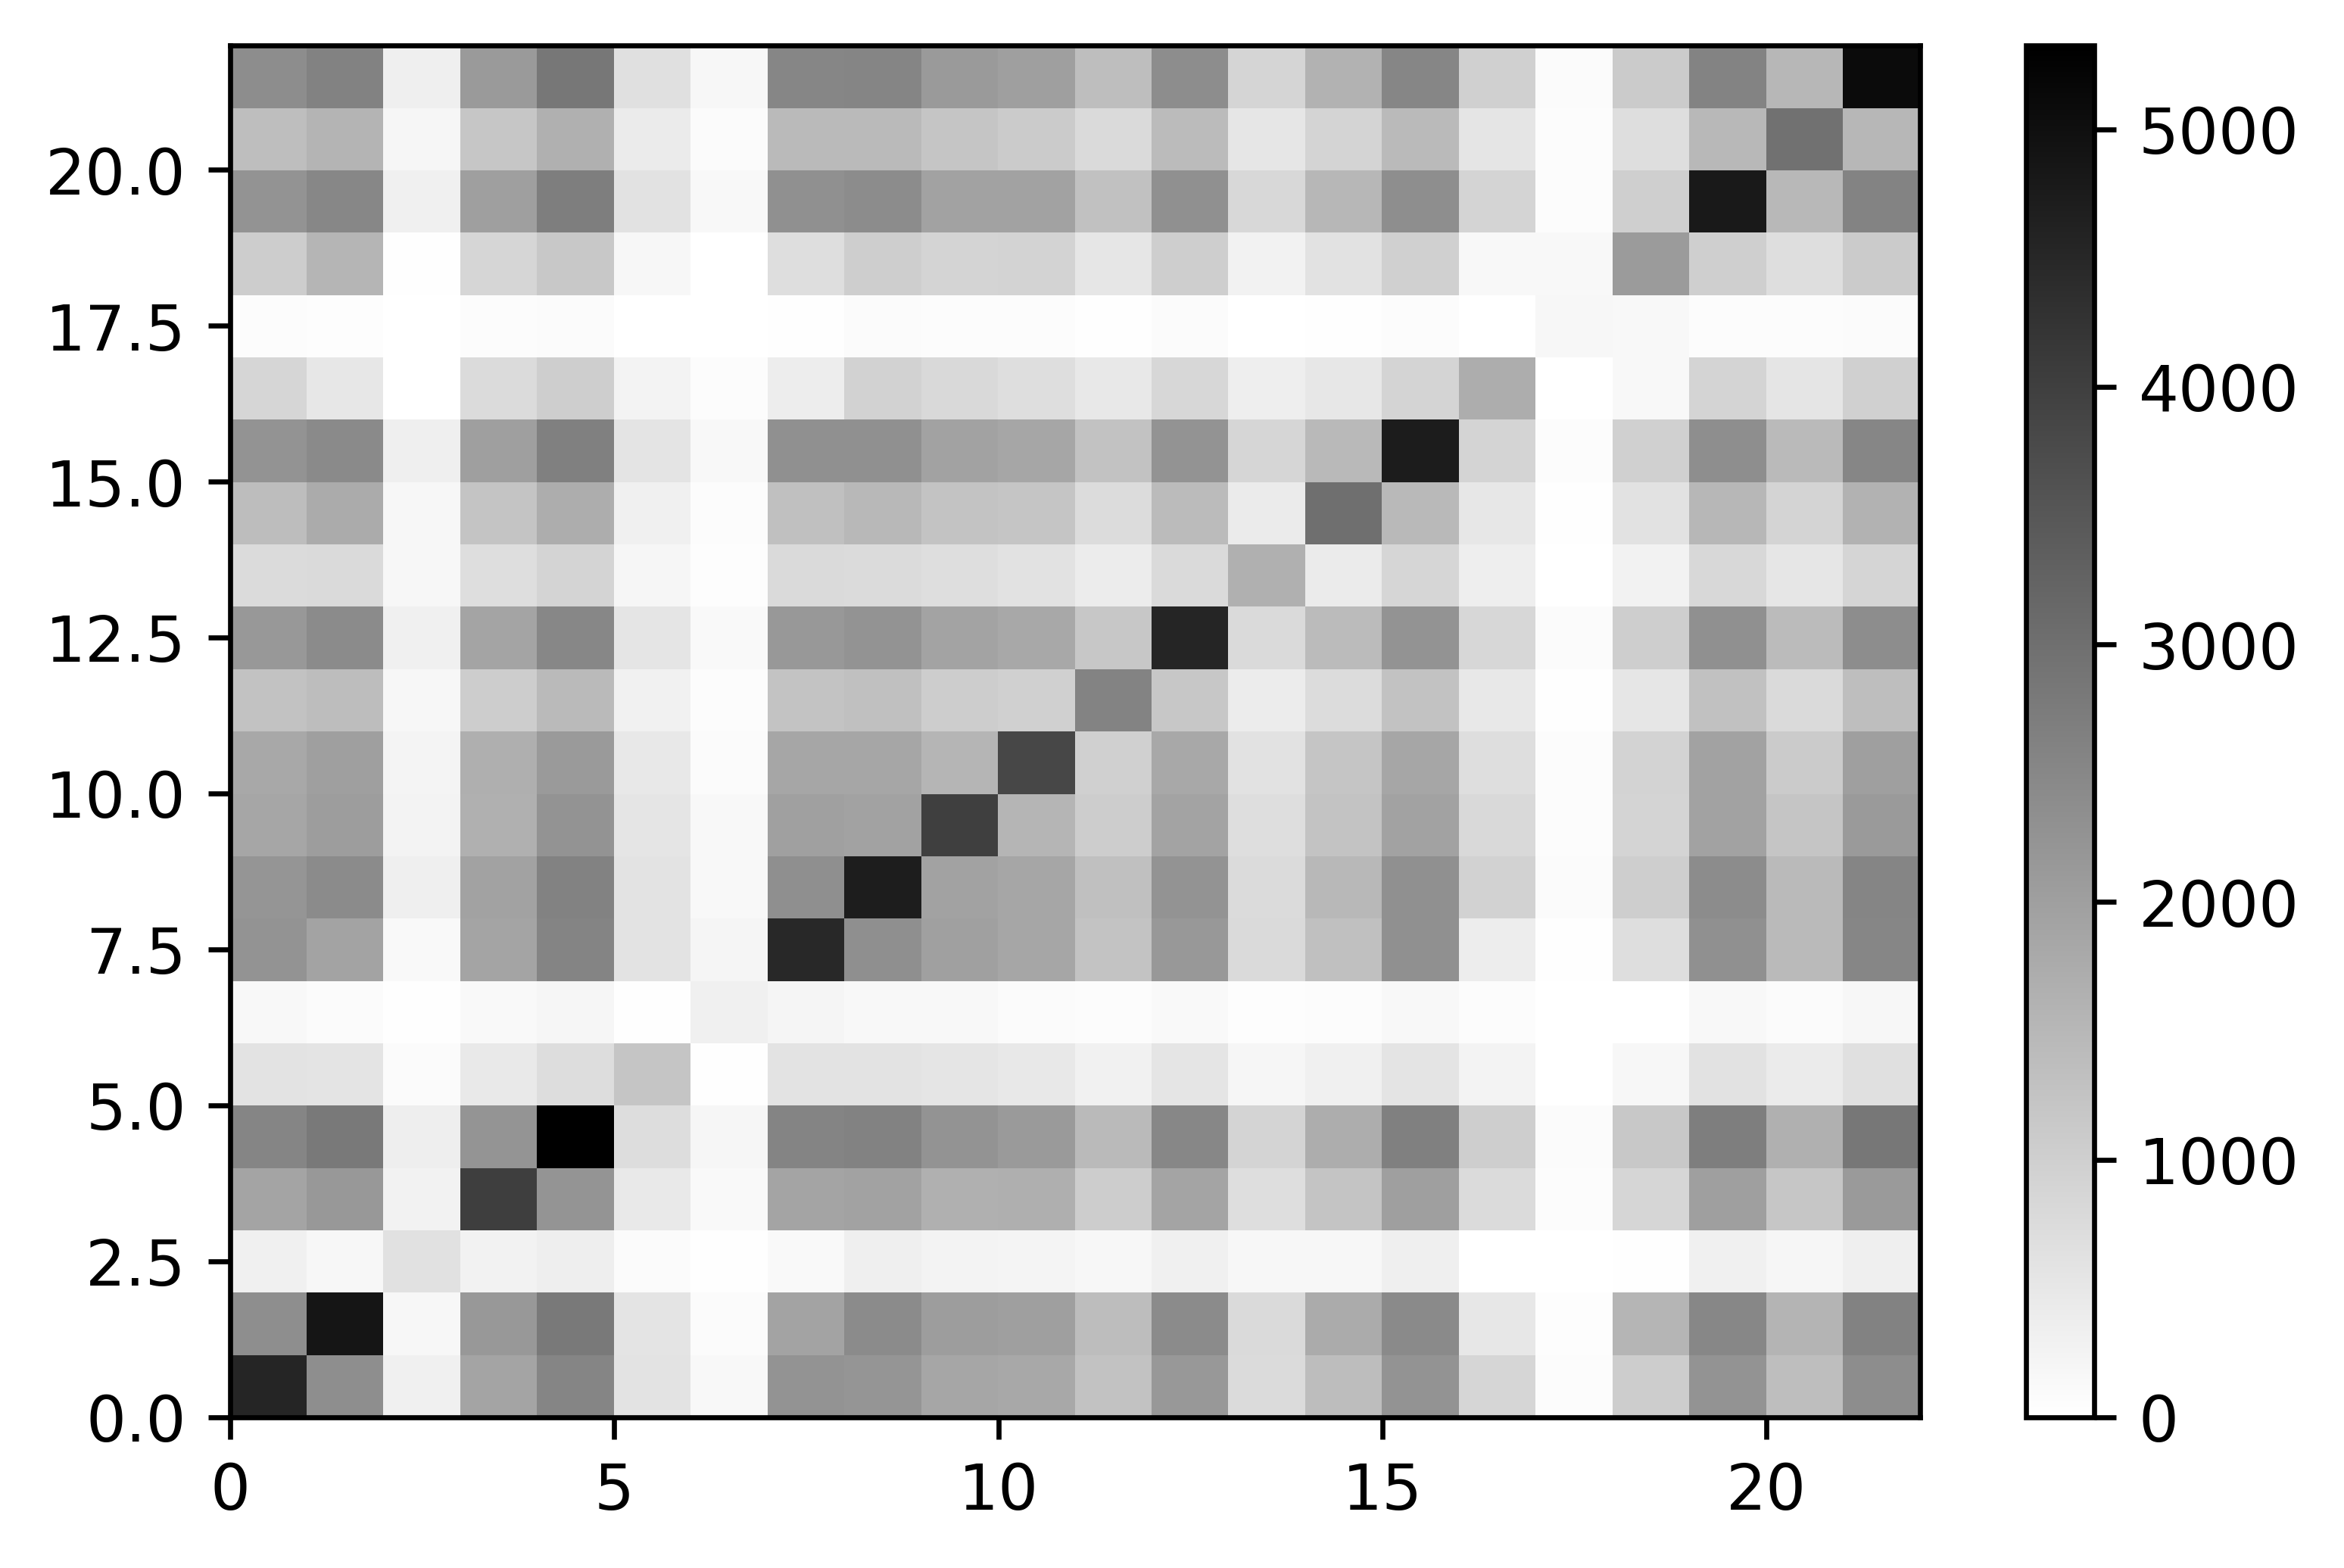

<Figure size 3600x2400 with 0 Axes>

In [32]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600

plt.colorbar(plt.pcolor(shared_samples_count, cmap='binary'))
plt.show()
plt.savefig('shared_samples_count.png', dpi=300)